# Assignment 2: Fine-Tuning a Language Model for an NLP Problem

# I、Introduction

## 1. Task Description:

The aim of this project is to perform cryptocurrency tweet classification by first obtaining the Bitcoin tweets [sentiment analysis] dataset from kaggle, then performing data preprocessing including data cleaning, text encoding preprocessing, and dealing with data imbalance, followed by model construction and fine-tuning, and finally performing model evaluation through visualization and result analysis, and summarizing and discussing the obstacles encountered and solutions employed and potential improvements or future directions.

This experiment is accomplished by renting NVIDIA RTX 3090 (24GB) GPU resources provided by the AutoDL platform.

## 2. Reasons for topic selection

Cryptocurrencies are decentralized digital assets based on blockchain technology, securing transactions through cryptography and featuring anonymity, tamperability and global circulation. The mainstream cryptocurrencies are Bitcoin and Ether. It serves as a new payment tool that bypasses the traditional banking system, effectively reducing the cost of remittances, and has become a high-risk, high-yield asset to invest in due to its much higher volatility than stocks and gold.

And changes in people's sentiment toward cryptocurrencies can have a profound effect on prices, liquidity, duration structures and even the entire financial ecosystem. For example, in 2021 when Musk announced that Tesla was suspending Bitcoin payments, the price of Bitcoin plummeted 15% in 24 hours, while DOGE rose over 12,000% in 2021 due to the collective bullish sentiment of the Reddit community and celebrity tweets. And while positive sentiment can lead to more people buying, so the bid-ask spread narrows, transactions are more frequent, and the market comes alive, negative sentiment can cause liquidity to dry up and prices to plummet, paralyzing the market completely. Being able to categorize and then predict the direction of people's emotions, we can know the trend of cryptocurrency prices, liquidity and other changes, and we can effectively respond.

For example, individual investors can find the right time to bottom out or reduce their positions; institutional investors can combine sentiment and market liquidity for strategic analysis, such as high-frequency market-making to earn spreads when sentiment is positive and order volume increases; cryptocurrency exchanges can manage liquidity and protect users, such as pop-up windows to prompt risks when sentiment is too high; regulators can carry out market monitoring and policy intervention.

## 3. Reasons for choosing the BERT model

First, BERT allows for two-way parsing.BERT uses the Encoder part of the Transformer, which allows the model to take into account all the other elements in the sequence as it processes each element, and can encode each word while taking into account its contextual meaning, whereas the LSTM processes sequences sequentially, and can only access information about the context prior to that element, and cannot access the entire sequence at once, as BERT can. LSTM processes sequences sequentially and can only access the context information before the element, but not the context of the whole sequence at the same time as BERT does.

Secondly, BERT can process the whole sequence in parallel due to the self-attention mechanism, which greatly speeds up the training of the model, while LSTM needs to process the sequence step by step and consumes more time due to its circular structure.

Meanwhile, BERT can capture long-distance dependencies more effectively, and because it is bigger and more complex than LSTM model with more parameters, it can capture more deep information such as utterance structure and semantic structure, and it has better training effect

Therefore, BERT performs better in deep understanding of context in this task, so BERT model is chosen.

# II、Data preprocessing

## 1.Data Set Acquisition

By comparing the contents of several kaggle and hugging face datasets, a dataset with a moderate amount of data and labeling was chosen: The Bitcoin tweets [Sentiment Analysis] dataset from kaggle has 77,398 texts, which are categorized into NEUTRAL, NEGATIVE, and POSITIVE sentiment. However, this project is going to remove the categorization of NEUTRAL, and carry out NEGATIVE and POSITIVE binary classification model training.

## 2.Data Cleaning

remove all Neutral labeled samples and keep only the Positive and Negative categories.

In [33]:
import pandas as pd

# Reading CSV files
file_path = './tweets2.csv'  # Make sure the path is correct
raw_data = pd.read_csv(file_path) #initial data

#Extract data from the text and sentiment_label columns
processed_data = raw_data[['text', 'sentiment_label']]  
# 1. extract the negative and positive columns for the binary classification problem
filtered_data = processed_data[processed_data['sentiment_label'].isin(['Negative', 'Positive'])]
# 2. Delete duplicate lines with the same text in the text column.
cleaned_data = filtered_data.drop_duplicates(subset='text')  

# Displays the first few lines of data to confirm a successful read
print(cleaned_data.head())
num_rows = filtered_data.shape[0]
print(f"Current Rows: {num_rows}") #Print the current line number

                                                text sentiment_label
3  In 2017, miners attempted to assert control ov...        Negative
4  Yearly Close \r\nMonthly Close\r\nDaily Close\...        Positive
5  $BTC\r\n\r\nBitcoin just closed the yearly can...        Positive
6  Bitcoin's 2021 yearly candle in the books!\r\n...        Positive
8  Looks like #Bitcoin is heading into 2022 with ...        Negative
Current Rows: 34139


/tmp/ipykernel_835/551558673.py:5: DtypeWarning: Columns (4,5,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv(file_path) #initial data


Problems encountered: UnicodeDecodeError on Linux systems because the file was not encoded in UTF-8. I saved all the contents of the file again in UTF-8.

In [35]:
import re
from langdetect import detect, LangDetectException

# 3.Remove noise and missing values: user mentions (@user), links (http://), special symbols (e.g. #BTC reserved for BTC).
def preprocess_text(text):
    # Handling missing values in data
    if pd.isna(text):
        return ""
    # Remove User Mentions
    text = re.sub(r'@\w+', '', text)
    # Remove link
    text = re.sub(r'http\S+', '', text)
    # Remove special symbols
    text = re.sub(r'[^\w\s]', '', text)
    return text

# 4.Filter non-English parts, refer to deepseek's code
def is_english(text):
    try:
        cleaned_text = preprocess_text(text)  # Clean the text first
        if len(cleaned_text) < 3:             # Skip to short text
            return False
        return detect(cleaned_text) == 'en'   # Detect if English
    except LangDetectException:
        return False

cleaned_data = cleaned_data[cleaned_data['text'].apply(is_english)]
print(cleaned_data.head())
print(f"Current Rows: {cleaned_data.shape[0]}")

                                                text sentiment_label
3  In 2017, miners attempted to assert control ov...        Negative
4  Yearly Close \r\nMonthly Close\r\nDaily Close\...        Positive
5  $BTC\r\n\r\nBitcoin just closed the yearly can...        Positive
6  Bitcoin's 2021 yearly candle in the books!\r\n...        Positive
8  Looks like #Bitcoin is heading into 2022 with ...        Negative
Current Rows: 33028


In [36]:
import os
os.environ['PATH'] = f"/root/.cargo/bin:{os.environ['PATH']}"  # Add the Rust path to the environment variable

# validate
!rustc --version
!cargo --version

rustc 1.86.0 (05f9846f8 2025-03-31)
cargo 1.86.0 (adf9b6ad1 2025-02-28)


In [37]:
import torch

# Check if CUDA is available
print("CUDA Available:", torch.cuda.is_available())  
print("GPU Name:", torch.cuda.get_device_name(0))  

# Check if GPU is available
assert torch.cuda.is_available(), "GPU is not available, please check hardware or driver!"
device = torch.device("cuda")  # Forcing the use of the GPU
print(f"current device: {device}")

CUDA Available: True
GPU Name: NVIDIA GeForce RTX 3090
current device: cuda


## 3.Text Preprocessing

In [38]:
from transformers import BertTokenizer
import numpy as np
from sklearn.model_selection import train_test_split

# Defining the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# GPU Encoding Functions 
def bert_encode(texts, max_length=128):
    """Encoding text into GPU tensor"""
    encodings = tokenizer(
        texts.tolist(),
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='pt'  # Return the PyTorch tensor
    )
    return encodings

# Numerical Labeling 
texts = cleaned_data['text'] # Extract text
labels = cleaned_data['sentiment_label'].map({'Negative': 0, 'Positive': 1}) # Extract labels

# Divide training set/validation set
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

# GPU encoded text
train_encodings = bert_encode(train_texts) 
val_encodings = bert_encode(val_texts)

## 4. Processing data imbalance

In [39]:
from sklearn.utils.class_weight import compute_class_weight

# Calculation of category weights 
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)# Use the compute_class_weight function to compute class weights.
# class_weight='balanced': specifies that the weight calculation method is 'balanced',
# which will automatically calculate the weights based on the number of samples in each class, making each class contribute equally to the total loss.
# Load the weight tensor to the GPU
class_weights = torch.tensor(class_weights, dtype=torch.float)

## 5. Save preprocessed data

In [40]:
from torch.utils.data import Dataset

# Defining the GPU Dataset
class TweetDataset(Dataset):
    def __init__(self, encodings, labels):        
        self.encodings = encodings 
        self.labels = labels
        
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]  
        return item

    def __len__(self):
        return len(self.labels)

# Create a Dataset and save it
train_labels_tensor = torch.tensor(train_labels.values)
val_labels_tensor = torch.tensor(val_labels.values)
train_dataset = TweetDataset(train_encodings, train_labels_tensor)
val_dataset = TweetDataset(val_encodings, val_labels_tensor)
# Save Dataset (contains GPU tensor, needs to be on the same device when loaded)
torch.save(train_dataset, 'train_dataset.pt')
torch.save(val_dataset, 'val_dataset.pt')

# Save raw data after cleaning
cleaned_data.to_csv('cleaned_tweets.csv', index=False)

# III、Model training and fine-tuning

## 1. Loading pre-trained BERT models

In [41]:
from transformers import BertForSequenceClassification, TrainingArguments, Trainer
from transformers import EarlyStoppingCallback

# Use BertForSequenceClassification to load the pre-trained BERT model and specify the number of output labels (binary classification problem).
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2
).to(device) 

/root/miniconda3/envs/mypytorch2.0/lib/python3.9/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 2. Configuring Training Parameters

In [42]:
# Configure training parameters via TrainingArguments, including number of training rounds, batch size, learning rate, weight decay, and so on.
# Enable mixed-precision training to speed up the training process and reduce the memory usage.
# Specify the evaluation strategy and saving strategy.
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,  # 3w+ data volume is usually 3-5 epochs, 3 is also sufficient
    per_device_train_batch_size=25,  # Because my GPU memory is RTX 3090, I can set the training batch size to 16-64, but too small is too slow, too big is faster but may reduce the model generalization ability).
    per_device_eval_batch_size=50,  # Usually set to 2x the training batch
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs',
    fp16=True,  # Enable mixed precision (requires GPU support)
    learning_rate=1e-4,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1")

/root/miniconda3/envs/mypytorch2.0/lib/python3.9/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


## 3. Definition of assessment indicators

In [43]:
# Define evaluation metrics functions to calculate accuracy and F1 scores.
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids # Extracts the real labels (label_ids) from the EvalPrediction object. 
    preds = pred.predictions.argmax(-1) # Extracts the predicted category index from the predictions property of the EvalPrediction object.
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='weighted')
    }

## 4. Create Trainer and train

In [44]:
# Create a Trainer object, passing in the model, training parameters, training dataset, validation dataset, evaluation metrics function, and callback function (e.g., early stop).
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset, # Training dataset
    eval_dataset=val_dataset, # Validation dataset
    compute_metrics=compute_metrics, # Calculation of assessment indicators
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)] # Model performance was monitored on the validation set with Early Stopping
)

# Initiate GPU training
trainer.train()

# Preservation of optimal models
trainer.save_model("best_model")  

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.168800,0.126022,0.955646,0.955567
2,0.069900,0.123872,0.963064,0.962888
3,0.016400,0.157279,0.968059,0.968048


# IV、Model Evaluation

Classification Report:
              precision    recall  f1-score   support

    Negative       0.96      0.95      0.95      2308
    Positive       0.97      0.98      0.98      4298

    accuracy                           0.97      6606
   macro avg       0.97      0.96      0.96      6606
weighted avg       0.97      0.97      0.97      6606



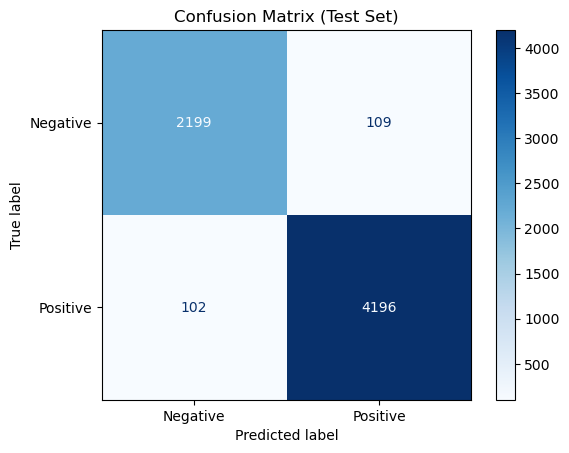

In [45]:
# Load test data to GPU
test_encodings = bert_encode(val_texts)  
test_labels_tensor = torch.tensor(val_labels.values)
test_dataset = TweetDataset(test_encodings, test_labels_tensor)

# GPU reasoning
predictions = trainer.predict(test_dataset)

# Move predictions back to CPU to compute metrics (sklearn does not support GPUs)
preds = np.argmax(predictions.predictions, axis=-1)
labels = predictions.label_ids

# Generate classification reports
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:")
print(classification_report(labels, preds, target_names=["Negative", "Positive"]))

# Drawing the confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Test Set)")
plt.savefig("confusion_matrix.png")
plt.show()

# V、Summary and analysis

## 1. Data challenges and pre-processing steps

Data Challenge:

I've been looking for more than 20 datasets on kaggle and Hugging Face, and finally found a 7w+ dataset about Classifying tweets on crypto coins and labeled (bullish vs. bearish sentiment). Because I want to train with BERT, it has many parameters, so the amount of data needed is also larger.
    This kind of text data will have noises like User Mentions, links, special symbols, spelling errors, etc. and need to be cleaned. And the dataset may be unbalanced (e.g. large gap between the number of positive and negative samples) and needs to be balanced.

Preprocessing Steps:

Firstly, data cleaning is carried out, and the words with positive and negative attitudes are selected for binary classification model training, and then special words, user names, Links, and non-English text data are removed.
    Then the text preprocessing is performed, using BertTokenizer in Hugging Face's transformers library to split and encode the text, and set the maximum sequence length (e.g., max_length=128), truncate the excessively long text, and fill in the short text to ensure that all the input sequences are of the same length, so that they can be batch processed and fed into the model. The training and validation sets are then divided.
    The data imbalance is then dealt with and the class weights are calculated using the class_weight='balanced' parameter.
    Finally the text encoding and labeling, with the training and validation datasets are saved into the TweetDataset dataset.

## 2. Model hyperparameters and architecture selection

Hyperparameter selection:

The parameters of the model include the number of rounds of training, the batch size for each training step, the batch size for each evaluation step, the learning rate, and the weight decay.
After querying, according to my data volume of 3w+ and using BERT to run on GPU, the number of training rounds is 3-5 rounds is reasonable, so I chose 3 rounds, the batch size of each training step is 16-64, too small is too slow, too big is faster but may reduce the model generalization ability, so I chose 25 times, the batch size of each evaluation step is twice the batch size of the training step, so I chose 50.
The learning rate is to control the step size of the model weight update, after querying 1e-3, 1e-4, 2e-5 are good, I chose 1e-4. weight decay is to prevent the model overfitting, after querying I chose 0.01.

Architecture Selection:

The BERT model was chosen as the underlying architecture. First, I configured the training parameters such as the number of training rounds, logging_dir, fp16, learning_rate, etc. Then we created the Trainer object and passed in the pre-trained BERT model, the training parameters, the evaluation metrics computation function and the dataset. Then start training, and save the best model after training.

## 3. Obstacles and solutions encountered

I encountered some problems in model training and solved them efficiently. Because the batch size of each training step and the batch size of each evaluation step that can be run at the same time is too small because of the low GPU version, the training was slow, so I rented NVIDIA RTX 3090 (24GB) GPU resources from Autodl platform to fine-tune the model. Because there was an imbalance in the data, I automatically calculated the weights based on the number of samples in each category so that each category's weight was inversely proportional to its number of samples. Because of the concern about model overfitting, I added an early stopping mechanism. When GPU memory was low, I deleted some files from the system disk ...


## 4. Potential improvements or future directions

Directions that can be improved:

1.data enhancement: try to use data enhancement techniques such as synonym replacement, random insertion etc. to increase data diversity. Also validate my model with different dataset. Also try more sophisticated text cleaning strategies (e.g., deactivation word removal, stemming extraction, etc.).

2.Model experimentation: try other pre-trained models such as RoBERTa, BERTweet and LSTM for fine-tuning, which also have their own advantages. Experiments can also be conducted using larger models such as BERT-large or smaller models such as DistilBERT, while the size of the experimental data also changes.

3.Parameter optimization: Adjust the parameters to do several sets of experiments to find the trend of accuracy change with the parameter change, such as epoches number of times to increase and decrease to see the change, to find the most suitable parameters.

4.Evaluation indicators: In addition to the classification report and confusion matrix, you can also try to calculate the AUC-ROC curve or PR curve to further analyze the model performance.